Previous: [pipeline_experiment](pipeline_experiment.ipynb)

# Schema `preprocess`

In [1]:
# make notebook display width scalable
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# make figures bigger
%pylab inline
pylab.rcParams['figure.figsize'] = (9, 8)

Populating the interactive namespace from numpy and matplotlib


The `preprocess` schema extracts, aligns, and synchronizes multiphoton trace data from both galvo and AOD systems.

In [2]:
import datajoint as dj
from pipeline import preprocess

DataJoint 0.3.2 (July 18, 2016)
Loading local settings from dj_local_conf.json


The ERD of the preprocess schema is a bit more complicated:

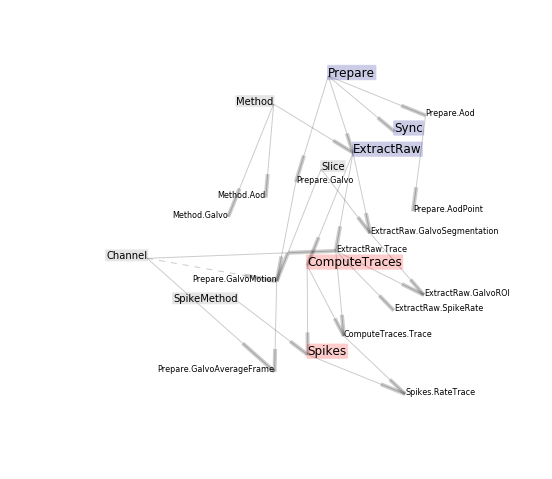

In [3]:
dj.ERD(preprocess).draw()

You may plot a portion of the ERD starting with any table.  Here +1 means go one level down along dependencies and -1 means go one level up from all nodes:

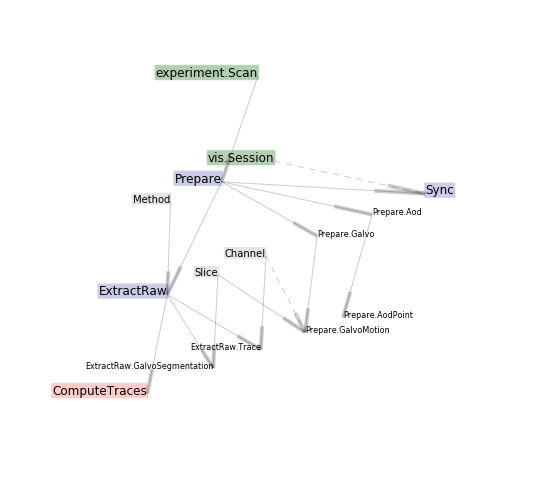

In [4]:
(dj.ERD(preprocess.Prepare())+2-1).draw()

The color code is the following: 
* Green (e.g. `experiment.Scan`) is data entered *manual* or by external software
* Blue (e.g. `preprocess.Prepare`) is data that is *imported* from external files by datajoint.
* Red (e.g. `preprocess.ComputeTraces`) is data that is *computed* by datajoint using data that is already in the database without access to external files.
* Gray (e.g. `preprocess.Method`) are *lookup* tables containing general information that is not specific each experiment.  These often contain processing settings and common knowledge. 
* In small font are part tables (e.g. `preprocess.Prepare.Galvo`).  These contain information listing additional details for its master table, its outer nesting class.

Many tables contain attributes of type `blob` or `longblob`, which contain array information such as images and traces:

In [5]:
preprocess.Prepare.GalvoAverageFrame().heading

# average frame for each slice and channel after corrections
animal_id            : int                          # id number
session              : smallint                     # session index for the mouse
scan_idx             : smallint                     # number of TIFF stack file
slice                : tinyint                      # slice in scan
channel              : tinyint                      # 
---
frame                : longblob                     # average frame ater Anscombe, max-weighting,

One can get identifying information for each row (the _primary key_ values) using the `keys` method of `fetch`:

In [6]:
from pipeline import experiment
scans = experiment.Scan() & (experiment.Session() & 'session_date="2016-06-16"' & 'username="jake"') &  preprocess.Prepare.GalvoAverageFrame()
for key in scans.fetch.keys():
    print(key)


OrderedDict([('animal_id', 10144), ('session', 1), ('scan_idx', 1)])
OrderedDict([('animal_id', 10144), ('session', 1), ('scan_idx', 5)])
OrderedDict([('animal_id', 10144), ('session', 1), ('scan_idx', 8)])
OrderedDict([('animal_id', 10144), ('session', 1), ('scan_idx', 9)])


These may be used in restrictions.  Let's plot average frames for the second entry in `scans`:

In [7]:
keys = list((scans*preprocess.Slice()).fetch.keys())
frames = preprocess.Prepare.GalvoAverageFrame() & keys[1]
frames 

animal_id,session,scan_idx,slice,channel
10144,1,5,1,1
10144,1,5,1,2


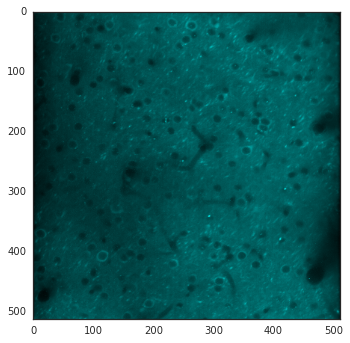

In [8]:
g, b = frames.fetch['frame']
normalize = lambda x: (x - x.min())/(x.max()-x.min())
import seaborn as sns
I = np.stack([np.zeros_like(g), normalize(b), normalize(b)],2)
with sns.axes_style('white'):
    fig,axe = plt.subplots()
axe.imshow(I)

In [9]:
# Let's check the fluorohpore for this key
experiment.Session.Fluorophore() & keys[1]

animal_id,session,fluorophore,notes
10144,1,Twitch2B,


Next: [pipeline_vis](pipeline_vis.ipynb)